# Y2H quality control checks

Here we're looking for any potential problems with any of the ~500 Y2H large plates. There are 3 replicates for each plate. We look for problems by plotting different metrics and comparing between all the plates using the same media and within the replicates. 

**NOTE: we previously found swapped and mislabelled plates. Those have now been corrected in the database (22nd Nov 2019). The comments below refer to those findings and now don't match the plots/data.**

In [1]:
import os
import re
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from plotting import validation_plot, checkerboard

In [143]:
fig_dir = Path('../figures/Y2H_QC')
os.makedirs(fig_dir, exist_ok=True)

In [3]:
qry = """select *
            from tf_screen.tf_isoform_final
            left join tf_screen.retest
            using (retest_id);"""
df = pd.read_sql(qry, ccsblib.paros_connection())
df = df.loc[:, ['standard_batch', 'retest_pla', 'retest_pos', 'seq_confirmation'] +
               [c for c in df.columns if c.endswith('_score') and '_repeat_' in c]]
df = df.drop_duplicates()
df = df.melt(id_vars=['standard_batch', 'retest_pla', 'retest_pos', 'seq_confirmation'],
             value_vars=[c for c in df.columns if c.endswith('_score')],
             var_name='media_rep',
             value_name='score')

In [4]:
df['media'] = df['media_rep'].apply(lambda x: {'lw': 'LW', 'chx': 'CX', '3at': 'AT'}[x.split('_')[0]])
df['rep'] = df['media_rep'].apply(lambda x: 'ABC'[int(x.split('_')[2]) - 1])
df.head()

,standard_batch,retest_pla,retest_pos,seq_confirmation,media_rep,score,media,rep
0,TFr11,1,F01,y,3at_repeat_1_score,0.0,AT,A
1,TFr11,1,E02,y,3at_repeat_1_score,0.0,AT,A
2,TFr11,1,D02,y,3at_repeat_1_score,0.0,AT,A
3,TFr11,1,C02,None,3at_repeat_1_score,0.0,AT,A
4,TFr11,1,B02,y,3at_repeat_1_score,2.5,AT,A


In [6]:
base_dir = '/Volumes/mvidal/projects/TF_Iso_Var/Y2H_TF_Iso/191106_grab_all_tfiso_colony_images/a_all_colony_images'
all_img_files = os.listdir(base_dir)

# TODO: fix this now that two of the images have been deleted
def big_plate_image(row):
    file_regexp = ('{std_batch}.{media}.rep{rep}(_([0-9]{{3}}|xxx|xx|XXX)){{6}}.JPG'
                       .format(std_batch=row['standard_batch'],
                               media=row['media'],
                               rep=row['rep']))
    matching_files = [s for s in all_img_files
                        if re.match(file_regexp, s)
                        and str(row['retest_pla']).zfill(3) in s]
    if len(matching_files) == 0:
        return np.nan
        #raise UserWarning('could not find file for plate: {} matching: {}'.format(row['retest_pla'], file_regexp))
    if len(matching_files) > 1:
        raise UserWarning('found multiple files matching ' + file_regexp)
    return matching_files[0]

df_b = df.loc[:, ['standard_batch', 'retest_pla', 'media', 'rep']].drop_duplicates().copy()
df_b['big_plate'] = df_b.apply(big_plate_image, axis=1)
df = pd.merge(df, df_b, on=['standard_batch', 'retest_pla', 'media', 'rep'], how='left')

In [7]:
df.head()

,standard_batch,retest_pla,retest_pos,seq_confirmation,media_rep,score,media,rep,big_plate
0,TFr11,1,F01,y,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
1,TFr11,1,E02,y,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
2,TFr11,1,D02,y,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
3,TFr11,1,C02,None,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
4,TFr11,1,B02,y,3at_repeat_1_score,2.5,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG


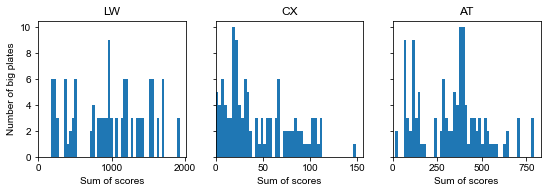

In [45]:
# negative scores are NA
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 2.5)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(df.loc[(df['media'] == media) & 
                   (df['score'] >= 0) , :]
              .groupby('big_plate')['score'].sum(),
            bins=50)
    ax.set_xlim(0, None)
    ax.set_xlabel('Sum of scores')
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'sum_of_scores.pdf'),
            bbox_inches='tight')

In [10]:
(df.loc[(df['media'] == 'LW') & 
                   (df['score'] >= 0) , :]
              .groupby('big_plate')['score'].sum()).sort_values()

big_plate
TFr07.LW.repC_061_062_063_064_065_066.JPG     176.0
TFr07.LW.repB_061_062_063_064_065_066.JPG     176.0
TFr07.LW.repA_061_062_063_064_065_066.JPG     176.0
TFr12.LW.repC_xxx_xxx_035_xxx_xxx_xxx.JPG     188.0
TFr12.LW.repA_035_xxx_xxx_xxx_xxx_xxx.JPG     192.0
                                              ...  
TFr09.LW.repB_001_002_003_004_005_006.JPG    1702.0
TFr09.LW.repA_001_002_003_004_005_006.JPG    1702.0
TFr09.LW.repA_013_014_015_016_017_018.JPG    1919.5
TFr09.LW.repB_013_014_015_016_017_018.JPG    1922.5
TFr09.LW.repC_013_014_015_016_017_018.JPG    1924.0
Name: score, Length: 117, dtype: float64

In [11]:
df.head()

,standard_batch,retest_pla,retest_pos,seq_confirmation,media_rep,score,media,rep,big_plate
0,TFr11,1,F01,y,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
1,TFr11,1,E02,y,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
2,TFr11,1,D02,y,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
3,TFr11,1,C02,None,3at_repeat_1_score,0.0,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG
4,TFr11,1,B02,y,3at_repeat_1_score,2.5,AT,A,TFr11.AT.repA_001_002_003_004_005_006.JPG


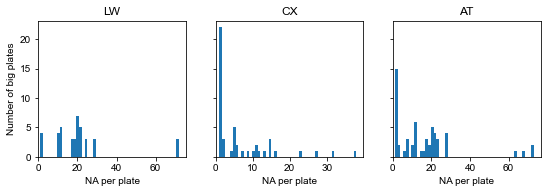

In [46]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 2.5)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(df.loc[(df['media'] == media) & 
                   (df['score'] < 0) , :]
              .groupby('big_plate').size(),
            bins=50)
    ax.set_xlim(0, None)
    ax.set_xlabel('NA per plate')
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'NA_per_big_plate.pdf'),
            bbox_inches='tight')

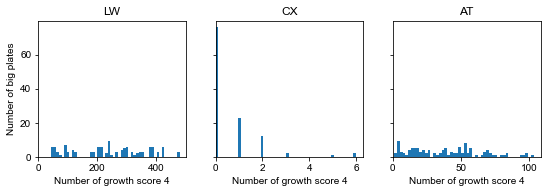

In [47]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 2.5)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(df.loc[(df['media'] == media), :]
              .groupby('big_plate')['score'].apply(lambda x: (x == 4).sum()),
            bins=50)
    ax.set_xlim(0, None)
    ax.set_xlabel('Number of growth score 4')
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'growth_score_4_per_big_plate.pdf'),
            bbox_inches='tight')

In [48]:
# CHX with the most growth score 4
(df.loc[(df['media'] == 'CX'), :]
   .groupby('big_plate')['score']
   .apply(lambda x: (x == 4).sum())
   .sort_values(ascending=False).head())

big_plate
TFr09.CX.repC_025_026_027_028_029_030.JPG    6
TFr09.CX.repB_025_026_027_028_029_030.JPG    6
TFr09.CX.repB_019_020_021_022_023_024.JPG    5
TFr09.CX.repB_031_032_033_034_035_036.JPG    3
TFr09.CX.repA_025_026_027_028_029_030.JPG    3
Name: score, dtype: int64

In [49]:
# CHX with most overall growth
(df.loc[df['media'] == 'CX', :]
     .groupby('big_plate')['score'].sum()
    .sort_values(ascending=False).head())

big_plate
TFr09.CX.repB_019_020_021_022_023_024.JPG    149.0
TFr09.CX.repA_001_002_003_004_005_006.JPG    113.0
TFr09.CX.repA_007_008_009_010_011_012.JPG    110.0
TFr09.CX.repA_019_020_021_022_023_024.JPG    109.5
TFr09.CX.repB_037_038_039_040_041_042.JPG    109.0
Name: score, dtype: float64

In [50]:
# CHX with most nulls
(df.loc[(df['media'] == 'CX') &
        (df['score'] < 0), :]
     .groupby('big_plate')
     .size()
     .sort_values(ascending=False).head())

big_plate
TFr11.CX.repB_007_008_009_010_011_012.JPG    38
TFr11.CX.repB_001_002_003_004_005_006.JPG    32
TFr11.CX.repA_019_020_021_022_023_024.JPG    27
TFr11.CX.repA_013_014_015_016_017_018.JPG    23
TFr12.CX.repC_019_020_021_022_023_024.JPG    16
dtype: int64

In [51]:
(df.loc[(df['media'] == 'AT') &
        (df['score'] < 0), :]
    .groupby('big_plate')
    .size()
    .sort_values(ascending=False).head())

big_plate
TFr12.AT.repC_019_020_021_022_023_024.JPG    73
TFr12.AT.repA_019_020_021_022_023_024.JPG    72
TFr12.AT.repB_019_020_021_022_023_024.JPG    68
TFr12.AT.repB_025_028_029_030_xxx_xxx.JPG    64
TFr12.AT.repA_025_028_029_030_xxx_xxx.JPG    27
dtype: int64

In [52]:
# correlations between replicates
df['big_plate_grouping'] = df['big_plate'].str.replace('rep[ABC]', '')
df['plate_pos'] = df['retest_pla'].astype(str) + '_' + df['retest_pos']

def min_corr_reps(rows):
    return rows.pivot(index='plate_pos', columns='rep', values='score').corr().min().min()


def idx_min_corr_reps(rows):
    return rows.pivot(index='plate_pos', columns='rep', values='score').corr().stack().idxmin()


def mean_abs_diff_reps(rows):
    d = rows.pivot(index='plate_pos', columns='rep', values='score')
    if 'A' in d.columns and 'B' in d.columns:
        d_ab = (d['A'] - d['B']).abs().sum() / (d['A'].notnull() & d['B'].notnull()).sum()
    else:
        d_ab = 0
    if 'A' in d.columns and 'C' in d.columns:
        d_ac = (d['A'] - d['C']).abs().sum() / (d['A'].notnull() & d['C'].notnull()).sum()
    else:
        d_ac = 0
    if 'B' in d.columns and 'C' in d.columns:
        d_bc = (d['B'] - d['C']).abs().sum() / (d['B'].notnull() & d['C'].notnull()).sum()
    else:
        d_bc = 0
    return max([d_ab, d_ac, d_bc])

reps = df.groupby('big_plate_grouping').apply(min_corr_reps).rename('min_pcc').to_frame()
reps = reps.loc[(df.groupby('big_plate_grouping')['rep'].nunique() > 1), :]
reps = reps.dropna()
reps['min_pair'] = df.loc[df['big_plate_grouping'].isin(reps.index), :].groupby('big_plate_grouping').apply(idx_min_corr_reps)
reps['mean_abs_diff'] = df.loc[df['big_plate_grouping'].isin(reps.index), :].groupby('big_plate_grouping').apply(mean_abs_diff_reps)

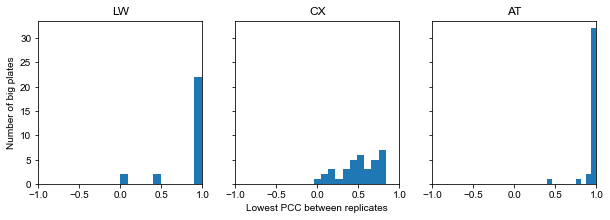

In [53]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(10, 3)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(reps.loc[reps.index.map(lambda x: media in x), 'min_pcc'])
    ax.set_xlim(-1, 1)
axes[1].set_xlabel('Lowest PCC between replicates');
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'replicate_pcc.pdf'),
            bbox_inches='tight')

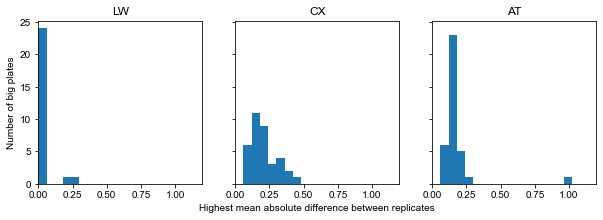

In [54]:
fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(10, 3)
for ax, media in zip(axes, ['LW', 'CX', 'AT']):
    ax.set_title(media)
    ax.hist(reps.loc[reps.index.map(lambda x: media in x), 'mean_abs_diff'],
            bins=20,
            range=(0., 1.2))
    ax.set_xlim(0, 1.2)
axes[1].set_xlabel('Highest mean absolute difference between replicates');
axes[0].set_ylabel('Number of big plates')
plt.savefig(os.path.join(fig_dir, 'replicate_mean_abs_diff.pdf'),
            bbox_inches='tight')

## Some notes after following up by looking at the plate images

### PCC between replicates

3 low values for 3AT:
- `TFr09.AT._031_032_033_034_035_036.JPG` `A/B`
    - This is the swapped 3AT/CHX plates that we previously identified.
- `TFr12.AT._025_028_029_030_xxx_xxx.JPG` `A/B`
    - plate 25 is missing from `TFr12.AT.repB_025_028_029_030_xxx_xxx.JPG`
- `TFr07.AT._097_098_099_100_101_102.JPG` `B/C`
    - Only one spot is growing on: `TFr07.AT.repB_097_098_099_100_101_102.JPG`. It appears that it is CHX, since it has identical growth to the CHX plate. It is not a swap or a duplicate image though. 

4 low values for -LW:
- `TFr07.LW._019_020_021_022_023_024.JPG` `A/B`
- `TFr07.LW._067_068_069_070_071_072.JPG` `B/C`
- `TFr07.LW._013_014_015_016_017_018.JPG` `A/B`
- `TFr09.LW._013_014_015_016_017_018.JPG` `A/B`
    - The pictures of all four pairs of plates look virtually identical.
    - The values are also close to identical
    - This is an artifact of using PCC when there is very little variance of the values
    
    
    
### Mean absolute difference between replicates

Highest value for -LW:
- `TFr12.LW._031_032_033_034_xxx_xxx.JPG`
    Looks fine. Just some shifting from 4 -> 3
    
    
Highest values for CHX:
- `TFr07.CX._031_032_033_034_035_036.JPG`
    - This is a 3AT plate. Has the same pattern of growth but does not appear to be a swap with other images.
- `TFr09.CX._031_032_033_034_035_036.JPG`
    - This is the swap we already identified
- `TFr07.CX._055_056_057_058_059_060.JPG`
    - Looks OK. Couple of strong growing wells in rep A and not in B/C 
- `TFr11.CX._007_008_009_010_011_012.JPG`
    - Some spotting trouble for replicate B


In [55]:
reps.sort_values('min_pcc').head(30)

,min_pcc,min_pair,mean_abs_diff
big_plate_grouping,,,
TFr07.CX._079_080_081_082_083_084.JPG,-0.041698,"(A, B)",0.229508
TFr07.LW._019_020_021_022_023_024.JPG,-0.005135,"(A, B)",0.010204
TFr07.LW._067_068_069_070_071_072.JPG,-0.003436,"(B, C)",0.011986
TFr07.CX._037_038_039_040_041_042.JPG,0.100631,"(B, C)",0.265625
TFr11.CX._007_008_009_010_011_012.JPG,0.120300,"(A, B)",0.444444
TFr11.CX._001_002_003_004_005_006.JPG,0.134618,"(B, C)",0.312044
TFr07.CX._049_050_051_052_053_054.JPG,0.173436,"(A, B)",0.243446
TFr07.CX._031_032_033_034_035_036.JPG,0.175477,"(B, C)",0.114754
TFr07.CX._067_068_069_070_071_072.JPG,0.228198,"(A, B)",0.147260


In [56]:
reps.sort_values('mean_abs_diff', ascending=False).head(30)

,min_pcc,min_pair,mean_abs_diff
big_plate_grouping,,,
TFr12.AT._025_028_029_030_xxx_xxx.JPG,0.398003,"(A, B)",0.980769
TFr11.CX._007_008_009_010_011_012.JPG,0.120300,"(A, B)",0.444444
TFr11.CX._013_014_015_016_017_018.JPG,0.378363,"(A, B)",0.383540
TFr07.CX._061_062_063_064_065_066.JPG,0.426871,"(A, B)",0.363636
TFr11.CX._019_020_021_022_023_024.JPG,0.427155,"(A, B)",0.348214
TFr11.CX._001_002_003_004_005_006.JPG,0.134618,"(B, C)",0.312044
TFr12.CX._019_020_021_022_023_024.JPG,0.564410,"(B, C)",0.302632
TFr12.CX._013_014_015_016_017_018.JPG,0.460721,"(A, C)",0.300412
TFr12.LW._031_032_033_034_xxx_xxx.JPG,0.926428,"(A, B)",0.282258


In [57]:
# check that this 3AT plate that is actually CHX has been set to null
(df.loc[(df['big_plate_grouping'] == 'TFr07.AT._097_098_099_100_101_102.JPG') &
       (df['rep'] == 'B'), 'score'] == -1).all()

True

In [58]:
# check that CHX plate that is actually 3AT has been set to null
(df.loc[(df['big_plate_grouping'] == 'TFr07.CX._031_032_033_034_035_036.JPG') &
       (df['rep'] == 'A'), 'score'] == -1).all()

True

In [71]:
# getting litbm / rrs data

# - TFr09/10 missing from retest_source so use dummy variable in join
# - TFr12 table is different from others, which is why all column names
#   specified 
qry_full = """
select a.*, b.category, c.seq_confirmation
from
(
select ad_orf_id, db_orf_id,
	   3at_repeat_1_score,
	   3at_repeat_2_score,
	   3at_repeat_3_score,
	   lw_repeat_1_score,
	   lw_repeat_2_score,
	   lw_repeat_3_score,
	   chx_repeat_1_score,
	   chx_repeat_2_score,
	   chx_repeat_3_score,
	   'TFr07' as standard_batch_dummy,
       'TFr07' as standard_batch
from tf_screen.tfr07_all
union all
select ad_orf_id, db_orf_id,
	   3at_repeat_1_score,
	   3at_repeat_2_score,
	   3at_repeat_3_score,
	   lw_repeat_1_score,
	   lw_repeat_2_score,
	   lw_repeat_3_score,
	   chx_repeat_1_score,
	   chx_repeat_2_score,
	   chx_repeat_3_score,
	   'TFr08' as standard_batch_dummy,
       'TFr08' as standard_batch
from tf_screen.tfr08_all
union all
select ad_orf_id, db_orf_id,
	   3at_repeat_1_score,
	   3at_repeat_2_score,
	   3at_repeat_3_score,
	   lw_repeat_1_score,
	   lw_repeat_2_score,
	   lw_repeat_3_score,
	   chx_repeat_1_score,
	   chx_repeat_2_score,
	   chx_repeat_3_score,
	   'TFr07' as standard_batch_dummy,
       'TFr09' as standard_batch
from tf_screen.tfr09_all
union all
select ad_orf_id, db_orf_id,
	   3at_repeat_1_score,
	   3at_repeat_2_score,
	   3at_repeat_3_score,
	   lw_repeat_1_score,
	   lw_repeat_2_score,
	   lw_repeat_3_score,
	   chx_repeat_1_score,
	   chx_repeat_2_score,
	   chx_repeat_3_score,
	   'TFr08' as standard_batch_dummy,
       'TFr10' as standard_batch
from tf_screen.tfr10_all
union all
select ad_orf_id, db_orf_id,
	   3at_repeat_1_score,
	   3at_repeat_2_score,
	   3at_repeat_3_score,
	   lw_repeat_1_score,
	   lw_repeat_2_score,
	   lw_repeat_3_score,
	   chx_repeat_1_score,
	   chx_repeat_2_score,
	   chx_repeat_3_score,
	   'TFr11' as standard_batch_dummy,
       'TFr11' as standard_batch
from tf_screen.tfr11_all
union all
select ad_orf_id, db_orf_id,
	   3at_repeat_1_score,
	   3at_repeat_2_score,
	   3at_repeat_3_score,
	   lw_repeat_1_score,
	   lw_repeat_2_score,
	   lw_repeat_3_score,
	   chx_repeat_1_score,
	   chx_repeat_2_score,
	   chx_repeat_3_score,
	   'TFr12' as standard_batch_dummy,
       'TFr12' as standard_batch
from tf_screen.tfr12_final) as a
inner join tf_screen.retest_source as b
on a.ad_orf_id = b.ad_orf_id
and a.db_orf_id = b.db_orf_id
and a.standard_batch_dummy = b.standard_batch
left join tf_screen.retest as c
on a.ad_orf_id = c.ad_orf_id
and a.db_orf_id = c.db_orf_id
and a.standard_batch = c.standard_batch;
"""
df = pd.read_sql(qry_full, ccsblib.paros_connection(charset='ascii'))

In [18]:
df.loc[df['seq_confirmation'].isnull(), :]

,ad_orf_id,db_orf_id,3at_repeat_1_score,3at_repeat_2_score,3at_repeat_3_score,lw_repeat_1_score,lw_repeat_2_score,lw_repeat_3_score,chx_repeat_1_score,chx_repeat_2_score,chx_repeat_3_score,standard_batch_dummy,standard_batch,category,seq_confirmation
5,100824,7368,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr07,TFr07,litbm,None
12,101283,5808,0.0,0.0,0.0,4.0,4.0,-1.0,0.0,0.0,0.0,TFr07,TFr07,rrs,None
33,101042,1579,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr07,TFr07,R6,None
34,100467,9577,0.0,0.0,0.0,4.0,4.0,4.0,1.0,0.0,0.0,TFr07,TFr07,rrs,None
42,101335,3364,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr07,TFr07,R6,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33400,100014,11788,2.0,2.0,2.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr12,TFr12,NA_NS,None
33407,100014,2040,0.0,1.0,1.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr12,TFr12,NA_NS,None
33408,100011,70218,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr12,TFr12,rrs,None
33420,100010,7826,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr12,TFr12,PDI_PPI,None


In [17]:
df.groupby('standard_batch')['seq_confirmation'].value_counts(dropna=False)

standard_batch  seq_confirmation
TFr07           y                   7236
                NaN                 1497
                wrong_id_db          513
                wrong_id_both        320
                wrong_id_ad          297
TFr08           y                   6906
                NaN                 1564
                wrong_id_db          572
                wrong_id_both        558
                wrong_id_ad          352
TFr09           y                   2666
                NaN                  695
                wrong_id_db          265
                wrong_id_ad          243
                wrong_id_both        124
TFr10           y                   2042
                NaN                  642
                wrong_id_db          311
                wrong_id_ad          131
                wrong_id_both         54
TFr11           y                    868
                NaN                  867
                wrong_id_ad           74
                wrong_id

In [35]:
df.groupby('standard_batch')['seq_confirmation'].value_counts(dropna=False) * 100 / df.groupby('standard_batch').size()

standard_batch  seq_confirmation
TFr07           y                   73.365102
                NaN                 15.177938
                wrong_id_db          5.201257
                wrong_id_both        3.244449
                wrong_id_ad          3.011254
TFr08           y                   69.393087
                NaN                 15.715434
                wrong_id_db          5.747588
                wrong_id_both        5.606913
                wrong_id_ad          3.536977
TFr09           y                   66.766842
                NaN                 17.405460
                wrong_id_db          6.636614
                wrong_id_ad          6.085650
                wrong_id_both        3.105435
TFr10           y                   64.213836
                NaN                 20.188679
                wrong_id_db          9.779874
                wrong_id_ad          4.119497
                wrong_id_both        1.698113
TFr11           y                   46.072187
 

In [40]:
df.loc[df['standard_batch'] == 'TFr11', 'category'].unique()

array(['TFr07_failed_plates', 'TFr10_redo', 'TFr09_redo',
       'TFr08_failed_plates'], dtype=object)

In [72]:
# add a column for redone pairs
# first, all pairs in TFr07/8 also in TFr09/10
# second, plates in TFr11 failed plates
df['pair_id'] = 'AD_' + df['ad_orf_id'].astype(str) + '_DB_' + df['db_orf_id'].astype(str)
df['redone'] = False
df.loc[(df['standard_batch'] == 'TFr07') &
       df['pair_id'].isin(df.loc[df['standard_batch'] == 'TFr09',
                                 'pair_id'].values), 'redone'] = True
df.loc[(df['standard_batch'] == 'TFr08') &
       df['pair_id'].isin(df.loc[df['standard_batch'] == 'TFr10',
                                 'pair_id'].values), 'redone'] = True
df.loc[(df['standard_batch'] == 'TFr07') &
       df['pair_id'].isin(df.loc[df['category'] == 'TFr07_failed_plates', 
                                 'pair_id'].values), 'redone'] = True
df.loc[(df['standard_batch'] == 'TFr08') &
       df['pair_id'].isin(df.loc[df['category'] == 'TFr08_failed_plates', 
                                 'pair_id'].values), 'redone'] = True

In [73]:
rrs_pairs = set(df.loc[df['category'].str.contains('rrs'), 'pair_id'].values)
lit_pairs = set(df.loc[df['category'].str.contains('lit'), 'pair_id'].values)

In [134]:
df.groupby('standard_batch')['pair_id'].apply(lambda x: x.isin(lit_pairs).sum())

standard_batch
TFr07    544
TFr08    451
TFr09    207
TFr10    191
TFr11    133
TFr12    225
Name: pair_id, dtype: int64

In [135]:
df.groupby('standard_batch')['pair_id'].apply(lambda x: x.isin(rrs_pairs).sum())

standard_batch
TFr07    464
TFr08    424
TFr09    181
TFr10    160
TFr11     96
TFr12    196
Name: pair_id, dtype: int64

In [136]:
df.loc[df['standard_batch'] == 'TFr07', 'category'].value_counts()

R6                           8776
litbm                         451
rrs                           424
R6,litbm                       84
ng_stem_cell_factor            79
R6,rrs                         40
ng_stem_cell_factor,litbm       9
Name: category, dtype: int64

In [74]:
for media in ['chx', '3at', 'lw']:
    for repeat in range(1, 4):
        column = '{}_repeat_{}_score'.format(media, repeat)
        df.loc[df[column] < 0, column] = np.nan
    cols_in = ['{}_repeat_{}_score'.format(media, r) for r in range(1, 4)]
    col_out = 'score_{}_mean'.format(media)
    df[col_out] = df[cols_in].mean(axis=1)

def score_pair(row):
    lw = row['score_lw_mean']
    at = row['score_3at_mean']
    chx = row['score_chx_mean']
    if pd.isnull([at, lw, chx]).any() or lw < 3:
        return 'NA'
    if (chx >= 1) and (at - chx < 1.5):
        return 'AA'
    if ((0.5 < at < 1) and (chx == 0)) or ((at - chx < 1.5) and (chx < 1) and (abs(at - chx) >= 0.5)):
        return 'NC'
    if ((chx == 0) and (at >= 1)) or (at - chx >= 1.5):
        return 'positive'
    if ((chx == 0) and (at <= 0.5)) or ((at - chx < 1.5) and (chx < 1) and (abs(at - chx) < 0.5)):
        return 'negative'
    raise UserWarning('should never get here')


df['score'] = df.apply(score_pair, axis=1)

In [75]:
df['result'] = np.nan
df.loc[(df['score'] == 'positive') & 
        (df['seq_confirmation'] == 'y'), 'result'] = True
df.loc[(df['score'] == 'negative') & 
        (df['seq_confirmation'] == 'y'), 'result'] = False

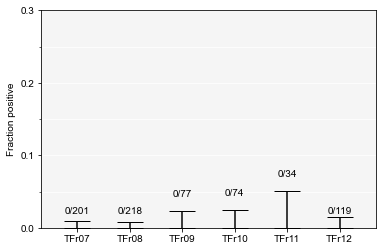

In [140]:
# fix the error bars
# fix which pairs were thrown out
experiments = df['standard_batch'].unique()
validation_plot(data=df.loc[df['pair_id'].isin(rrs_pairs)
                                 & (~df['redone']), :],
                     selections=[df['standard_batch'] == s for s in experiments],
                     labels=experiments,
                     y_max=0.3,
                     errorbar_capsize=0.1)
plt.savefig(fig_dir / 'RRS_by-experiment.pdf',
            bbox_inches='tight')
plt.show()

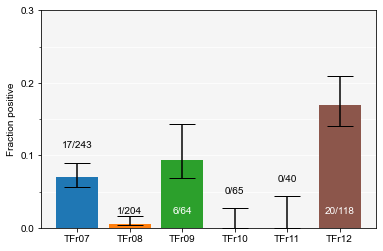

In [141]:
validation_plot(data=df.loc[df['pair_id'].isin(lit_pairs) &
                                 (~df['redone']),
                                 :],
                     selections=[df['standard_batch'] == s for s in experiments],
                     labels=experiments,
                     result_column='result',
                     y_max=0.3,
                     errorbar_capsize=0.1)
plt.savefig(fig_dir / 'Lit-BM_by-experiment.pdf',
            bbox_inches='tight')
plt.show()

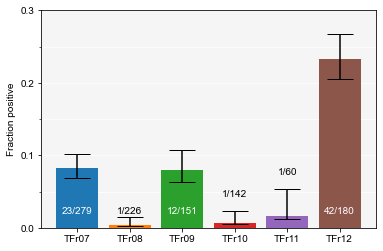

In [89]:
df['result_no_seq'] = np.nan
df.loc[(df['score'] == 'positive'), 'result_no_seq'] = True
df.loc[(df['score'] == 'negative'), 'result_no_seq'] = False
validation_plot(data=df.loc[df['pair_id'].isin(lit_pairs) &
                                 (~df['redone']),
                                 :],
                     selections=[df['standard_batch'] == s for s in experiments],
                     labels=experiments,
                     result_column='result_no_seq',
                     y_max=0.3,
                     errorbar_capsize=0.1)
plt.show()

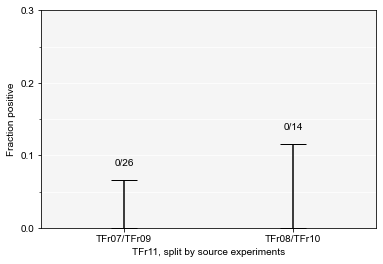

In [142]:
validation_plot(data=df.loc[df['pair_id'].isin(lit_pairs) &
                                 (df['standard_batch'] == 'TFr11'),
                                 :],
                     selections=[df['category'].isin(['TFr07_failed_plates', 'TFr09_redo']),
                                 df['category'].isin(['TFr08_failed_plates', 'TFr10_redo'])],
                     labels=['TFr07/TFr09', 'TFr08/TFr10'],
                     result_column='result',
                     y_max=0.3,
                     errorbar_capsize=0.1)
plt.xlabel('TFr11, split by source experiments')
plt.savefig(fig_dir / 'Lit-BM_TFr11-by-source-experiment.pdf',
            bbox_inches='tight')
plt.show()

In [129]:
# why is TFr11 so bad?
df.loc[(df['standard_batch'] == 'TFr11')
        & df['pair_id'].isin(lit_pairs), 'category'].value_counts()

TFr07_failed_plates    44
TFr09_redo             39
TFr10_redo             36
TFr08_failed_plates    14
Name: category, dtype: int64

In [100]:
res = df.loc[df['standard_batch'].isin(['TFr07', 'TFr08']) &
        df['category'].str.contains('lit'),
        ['pair_id', 'standard_batch', 'score', 'redone']].pivot(index='pair_id', columns='standard_batch', values='score').sort_values('TFr07')
res.tail(30)

standard_batch,TFr07,TFr08
pair_id,,
AD_100313_DB_604,positive,NaN
AD_100345_DB_10051,positive,NaN
AD_100355_DB_5107,positive,NaN
AD_100270_DB_13972,positive,NaN
AD_100247_DB_604,positive,NaN
AD_100244_DB_53657,positive,negative
AD_100218_DB_13972,positive,NaN
AD_101026_DB_8127,positive,NaN
AD_100178_DB_604,positive,NaN


In [76]:
pd.set_option('display.max_columns', 40)

In [104]:
(df.loc[df['pair_id'].isin(
    df.loc[(df['standard_batch'] == 'TFr07') &
            df['category'].str.contains('lit') &
            df['result'],
    'pair_id']), :]
    .sort_values(['pair_id', 'standard_batch']))

,ad_orf_id,db_orf_id,3at_repeat_1_score,3at_repeat_2_score,3at_repeat_3_score,lw_repeat_1_score,lw_repeat_2_score,lw_repeat_3_score,chx_repeat_1_score,chx_repeat_2_score,chx_repeat_3_score,standard_batch_dummy,standard_batch,category,seq_confirmation,score_chx_mean,score_3at_mean,score_lw_mean,score,result,pair_id,redone,result_no_seq
6585,100033,13972,4.0,4.0,4.0,4.0,4.0,4.0,0.5,0.0,1.0,TFr07,TFr07,"R6,litbm",y,0.500000,4.000000,4.0,positive,True,AD_100033_DB_13972,False,True
4315,100046,10820,1.5,2.0,2.5,4.0,4.0,4.0,0.0,1.0,0.0,TFr07,TFr07,"R6,litbm",y,0.333333,2.000000,4.0,positive,True,AD_100046_DB_10820,True,True
21675,100046,10820,3.0,2.5,3.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr07,TFr09,"R6,litbm",y,0.000000,2.833333,4.0,positive,True,AD_100046_DB_10820,False,True
33369,100046,10820,2.0,2.0,3.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr12,TFr12,litbm,y,0.000000,2.333333,4.0,positive,True,AD_100046_DB_10820,False,True
8803,100165,4126,2.0,2.5,2.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr07,TFr07,litbm,y,0.000000,2.166667,4.0,positive,True,AD_100165_DB_4126,False,True
10286,100165,4126,2.5,3.0,3.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr08,TFr08,litbm,y,0.000000,2.833333,4.0,positive,True,AD_100165_DB_4126,False,True
32806,100165,4126,2.0,2.0,3.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr12,TFr12,litbm,y,0.000000,2.333333,4.0,positive,True,AD_100165_DB_4126,False,True
6131,100178,604,4.0,4.0,4.0,4.0,4.0,4.0,0.0,1.0,0.0,TFr07,TFr07,"R6,litbm",y,0.333333,4.000000,4.0,positive,True,AD_100178_DB_604,False,True
6538,100218,13972,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr07,TFr07,"R6,litbm",y,0.000000,4.000000,4.0,positive,True,AD_100218_DB_13972,False,True
32714,100218,13972,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,TFr12,TFr12,litbm,None,0.000000,4.000000,4.0,positive,NaN,AD_100218_DB_13972,False,True


In [75]:
# why are the literature rates not consistent?
# was each isoform tested for each partner?
df.loc[(df['standard_batch'] == 'TFr07') &
        (df['category'].str.contains('lit')), 'redone'].sum()

251

In [110]:
a = set(df.loc[(df['standard_batch'] == 'TFr07') & df['category'].str.contains('lit'), 'pair_id'].values)
a_pos = set(df.loc[(df['standard_batch'] == 'TFr07') & df['category'].str.contains('lit')
            & (df['score'] == 'positive'), 'pair_id'].values)
b = set(df.loc[(df['standard_batch'] == 'TFr08') & df['category'].str.contains('lit'), 'pair_id'].values)
print(len(b) / len(a))
print(len(b.intersection(a_pos)) / len(a_pos))

0.8290441176470589
0.2619047619047619


In [126]:
(len(b.intersection(a_pos)), len(a_pos))
from scipy import stats

print(len(b.intersection(a_pos)), len(a_pos))
stats.binom_test(len(b.intersection(a_pos)), len(a_pos), 0.83)

11 42


8.254577809694352e-16

In [125]:
# DEBUG: something must have gone wrong with data processing
# look for lit pairs that test positive in TFr07 and are not in TFr08
# in the original DB tables
a_pos.difference(b)

{'AD_100033_DB_13972',
 'AD_100046_DB_10820',
 'AD_100048_DB_13645',
 'AD_100157_DB_13645',
 'AD_100178_DB_604',
 'AD_100218_DB_13972',
 'AD_100247_DB_604',
 'AD_100270_DB_13972',
 'AD_100299_DB_5107',
 'AD_100313_DB_604',
 'AD_100345_DB_10051',
 'AD_100355_DB_5107',
 'AD_100429_DB_604',
 'AD_100444_DB_2455',
 'AD_100455_DB_604',
 'AD_100460_DB_604',
 'AD_100532_DB_7214',
 'AD_100565_DB_604',
 'AD_100644_DB_2455',
 'AD_100703_DB_604',
 'AD_100807_DB_8601',
 'AD_100813_DB_5107',
 'AD_101025_DB_8127',
 'AD_101026_DB_8127',
 'AD_101256_DB_10051',
 'AD_101256_DB_54731',
 'AD_101334_DB_13645',
 'AD_101411_DB_13972',
 'AD_101414_DB_10051',
 'AD_101414_DB_54731',
 'AD_101444_DB_7214'}

In [77]:
df.loc[(df['standard_batch'] == 'TFr08') &
        (df['category'].str.contains('lit')), :]

,ad_orf_id,db_orf_id,3at_repeat_1_score,3at_repeat_2_score,3at_repeat_3_score,lw_repeat_1_score,lw_repeat_2_score,lw_repeat_3_score,chx_repeat_1_score,chx_repeat_2_score,...,standard_batch,category,seq_confirmation,score_chx_mean,score_3at_mean,score_lw_mean,score,result,pair_id,redone
9863,101223,2486,0.0,0.0,2.0,4.0,4.0,4.0,1.0,0.0,...,TFr08,litbm,y,0.333333,0.666667,4.0,negative,False,AD_101223_DB_2486,True
9874,100128,7589,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,...,TFr08,litbm,None,0.000000,0.000000,4.0,negative,NaN,AD_100128_DB_7589,False
9886,100132,7589,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,...,TFr08,litbm,y,0.000000,0.000000,4.0,negative,False,AD_100132_DB_7589,False
9898,101115,7589,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,...,TFr08,litbm,y,0.000000,0.000000,4.0,negative,False,AD_101115_DB_7589,True
9910,101321,7589,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,...,TFr08,litbm,y,0.000000,0.000000,4.0,negative,False,AD_101321_DB_7589,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19435,100345,6699,0.0,0.5,0.0,4.0,4.0,4.0,2.0,3.5,...,TFr08,litbm,wrong_id_db,1.833333,0.166667,4.0,AA,NaN,AD_100345_DB_6699,True
19446,100448,6699,0.0,0.5,0.0,4.0,4.0,4.0,2.0,3.5,...,TFr08,litbm,y,1.833333,0.166667,4.0,AA,NaN,AD_100448_DB_6699,True
19751,101221,7987,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,...,TFr08,litbm,y,0.000000,0.000000,4.0,negative,False,AD_101221_DB_7987,False
19763,101222,7987,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,...,TFr08,litbm,y,0.000000,0.000000,4.0,negative,False,AD_101222_DB_7987,False


In [65]:
df.loc[(df['standard_batch'] == 'TFr07') &
       (df['category'].str.contains('lit')), 'db_orf_id'].value_counts()

56067        19
11805        18
100070227    17
52987        14
100011191    10
             ..
70947         2
71394         2
4468          2
4448          2
6432          2
Name: db_orf_id, Length: 119, dtype: int64

In [47]:
# TFr11 doesnt have categories
df.loc[df['standard_batch'] == 'TFr11', 'category'].unique()

array(['TFr07_failed_plates', 'TFr10_redo', 'TFr09_redo',
       'TFr08_failed_plates'], dtype=object)

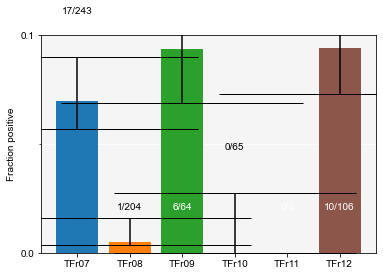

In [45]:
experiments = df['standard_batch'].unique()
validation_plot(data=df.loc[df['category'].str.contains('lit')
                                 & (~df['redone']), :],
                     selections=[df['standard_batch'] == s for s in experiments],
                     labels=experiments,
                     y_max=0.1)
plt.show()

In [169]:
from itertools import combinations

def n_shared_pairs(exp_a, exp_b):
    columns = ['pair_id', 'ad_orf_id', 'db_orf_id', 'score']
    pairs = pd.merge(df.loc[(df['standard_batch'] == exp_a)
                & (df['seq_confirmation'] == 'y')
                & ~df['redone'], 
                columns].copy(),
         df.loc[(df['standard_batch'] == exp_b)
                & (df['seq_confirmation'] == 'y')
                & ~df['redone'],
                columns].copy(),
         on=['pair_id', 'ad_orf_id', 'db_orf_id'],
         how='inner',
         suffixes=('_' + exp_a, '_' + exp_b))
    return pairs.shape[0]

pd.DataFrame([(a, b, n_shared_pairs(a, b)) for a, b in combinations(experiments, 2)],
             columns=['a', 'b', 'n_pairs_shared']).pivot(index='a', columns='b', values='n_pairs_shared').to_clipboard()

In [77]:
# pairwise comparisons of experiments:
# add in all possible scores
# remove NA and merge AA/NC?
exp_a = 'TFr08'
exp_b = 'TFr11'
columns = ['pair_id', 'ad_orf_id', 'db_orf_id', 'score']
pairs = pd.merge(df.loc[(df['standard_batch'] == exp_a)
                & (df['seq_confirmation'] == 'y')
                & ~df['redone'], 
                columns].copy(),
         df.loc[(df['standard_batch'] == exp_b)
                & (df['seq_confirmation'] == 'y')
                & ~df['redone'],
                columns].copy(),
         on=['pair_id', 'ad_orf_id', 'db_orf_id'],
         how='inner',
         suffixes=('_' + exp_a, '_' + exp_b))
print(pairs.shape[0])
(pairs.groupby(['score_' + exp_a, 'score_' + exp_b])
   .size()
   .rename('number of pairs')
   .reset_index()
   .pivot(index='score_' + exp_a, columns='score_' + exp_b, values='number of pairs')
   .fillna(0)
   .astype(int))

46


score_TFr11,AA,negative
score_TFr08,,
AA,5,0
negative,0,41


In [84]:
# pairwise comparisons of experiments:
# compare one to all other
exp_a = 'TFr12'
others = {'TFr' + str(i).zfill(2) for i in range(7, 13)}.difference({exp_a})
columns = ['pair_id', 'ad_orf_id', 'db_orf_id', 'score']
pairs = pd.merge(df.loc[(df['standard_batch'] == exp_a)
                & (df['seq_confirmation'] == 'y')
                & ~df['redone'], 
                columns].copy(),
         df.loc[(df['standard_batch'].isin(others))
                & (df['seq_confirmation'] == 'y')
                & ~df['redone'],
                columns].copy(),
         on=['pair_id', 'ad_orf_id', 'db_orf_id'],
         how='inner',
         suffixes=('_' + exp_a, '_others'))
print(pairs.shape[0])
(pairs.groupby(['score_' + exp_a, 'score_others'])
   .size()
   .rename('number of pairs')
   .reset_index()
   .pivot(index='score_' + exp_a, columns='score_others', values='number of pairs')
   .fillna(0)
   .astype(int))

544


score_others,AA,NA,NC,negative,positive
score_TFr12,,,,,
AA,21,0,3,14,0
NA,0,2,0,4,0
NC,9,4,8,7,3
negative,3,3,7,361,0
positive,18,20,12,0,45


In [4]:
# TODO: need to add in seqence confirmation
qry_r09_vs_r12 = """
select a.3at_repeat_1_score AS score_3AT_TFr09_1,
	   a.3at_repeat_2_score AS score_3AT_TFr09_2,
	   a.3at_repeat_3_score AS score_3AT_TFr09_3,
       a.lw_repeat_1_score AS score_LW_TFr09_1,
	   a.lw_repeat_2_score AS score_LW_TFr09_2,
	   a.lw_repeat_3_score AS score_LW_TFr09_3,
       a.chx_repeat_1_score AS score_CHX_TFr09_1,
	   a.chx_repeat_2_score AS score_CHX_TFr09_2,
	   a.chx_repeat_3_score AS score_CHX_TFr09_3,
	   b.3at_repeat_1_score AS score_3AT_TFr12_1,
	   b.3at_repeat_2_score AS score_3AT_TFr12_2,
	   b.3at_repeat_3_score AS score_3AT_TFr12_3,
       b.lw_repeat_1_score AS score_LW_TFr12_1,
	   b.lw_repeat_2_score AS score_LW_TFr12_2,
	   b.lw_repeat_3_score AS score_LW_TFr12_3,
       b.chx_repeat_1_score AS score_CHX_TFr12_1,
	   b.chx_repeat_2_score AS score_CHX_TFr12_2,
	   b.chx_repeat_3_score AS score_CHX_TFr12_3
from tf_screen.tfr09_all as a
inner join tf_screen.tfr12_final as b
using (ad_orf_id, db_orf_id)
where ad_orf_id is not Null
and db_orf_id is not Null;
"""
df = pd.read_sql(qry_r09_vs_r12, ccsblib.paros_connection())

In [5]:
for column in df.columns:
    df.loc[df[column] < 0, column] = np.nan

In [6]:
for media in ['3AT', 'CHX', 'LW']:
    for experiment in ['TFr09', 'TFr12']:
        cols_in = ['score_{}_{}_{}'.format(media, experiment, r) for r in range(1, 4)]
        col_out = 'score_{}_{}_mean'.format(media, experiment)
        df[col_out] = df[cols_in].mean(axis=1)

In [7]:
def score_pair(row, standard_batch):
    lw = row['score_LW_{}_mean'.format(standard_batch)]
    at = row['score_3AT_{}_mean'.format(standard_batch)]
    chx = row['score_CHX_{}_mean'.format(standard_batch)]
    if pd.isnull([at, lw, chx]).any() or lw < 3:
        return 'NA'
    if (chx >= 1) and (at - chx < 1.5):
        return 'AA'
    if ((0.5 < at < 1) and (chx == 0)) or ((at - chx < 1.5) and (chx < 1) and (abs(at - chx) >= 0.5)):
        return 'NC'
    if ((chx == 0) and (at >= 1)) or (at - chx >= 1.5):
        return 'positive'
    if ((chx == 0) and (at <= 0.5)) or ((at - chx < 1.5) and (chx < 1) and (abs(at - chx) < 0.5)):
        return 'negative'
    raise UserWarning('should never get here')

for batch in ['TFr09', 'TFr12']:
    df['result_' + batch] = df.apply(score_pair, axis=1, standard_batch=batch)

In [13]:
# need sequence confirmation
(df.groupby(['result_TFr09', 'result_TFr12'])
   .size()
   .rename('number of pairs')
   .reset_index()
   .pivot(index='result_TFr09', columns='result_TFr12', values='number of pairs')
   .fillna(0)
   .astype(int))

result_TFr12,AA,NA,NC,negative,positive
result_TFr09,,,,,
AA,31,1,19,31,29
NA,1,160,0,6,12
NC,3,5,12,19,11
negative,8,13,21,412,2
positive,6,33,13,1,278


0.8978276511259937


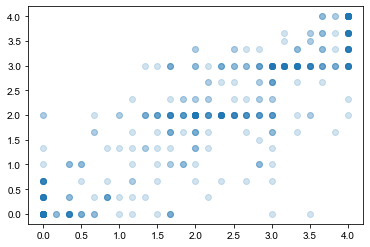

In [36]:
from scipy import stats
col_a = 'score_3AT_TFr09_mean'
col_b = 'score_3AT_TFr12_mean'
x, y = df[[col_a, col_b]].dropna().values.T
plt.scatter(x, y, alpha=0.2)
print(stats.pearsonr(x, y)[0] ** 2)

# PRS / RRS plate scores

In [67]:
qry = """select distinct scoring_pla, scoring_pos, manual_score_growth  
from  iscore.growth_result  
where large_plate_name like 'TFr%PRS%' 
order by scoring_pla, scoring_pos;"""
df = pd.read_sql(qry, ccsblib.paros_connection())
df.loc[df['scoring_pos'] == 'B08'].head(10)
df['standard_batch'] = df['scoring_pla'].str.slice(0, 5)
df['plate'] = df['scoring_pla'].str.slice(-1)
# 2 of the plates are switched in TFr12 relative to the other experiments 
df.loc[df['standard_batch'] == 'TFr12', 'plate'] = df.loc[df['standard_batch'] == 'TFr12', 'plate'].map({'1': '1', '2': '4', '3': '2', '4': '3'})
df['plate'] = df['plate'].map({'1': '1',
                               '2': '2R',
                               '3': '1R',
                               '4': '2'})
df['media'] = df['scoring_pla'].str.slice(8, 11).map({'r01': '3AT', 'r03': 'CHX', 'r02': 'LT'})
df = df.pivot_table(index=['standard_batch', 'plate', 'scoring_pos'],
               values='manual_score_growth',
               columns='media',
               aggfunc=lambda x: x).reset_index()
df.head()

media,standard_batch,plate,scoring_pos,3AT,CHX,LT
0,TFr07,1,A01,0,0,4
1,TFr07,1,A02,0,0,4
2,TFr07,1,A03,NA,NA,NA
3,TFr07,1,A04,0,0,4
4,TFr07,1,A05,0,0,4


In [68]:
def call_pair_result(row):
    """Lazy, just doing a quick rough version"""
    try:
        at = int(row['3AT'])
        cx = int(row['CHX'])
        return (at - cx) >= 1 
    except:
        return False


df['result'] = df.apply(call_pair_result, axis=1)

In [69]:
df.pivot_table(index=['plate', 'scoring_pos'],
               columns='standard_batch',
               values='result').drop(columns=['TFr08', 'TFr10', 'TFr11'])

standard_batch     TFr07  TFr09  TFr12
plate scoring_pos                     
1     A01          False  False  False
      A02          False  False  False
      A03          False  False  False
      A04          False  False  False
      A05          False  False  False
...                  ...    ...    ...
2R    H08          False   True   True
      H09          False  False  False
      H10          False  False  False
      H11          False  False   True
      H12          False  False  False

[384 rows x 3 columns]

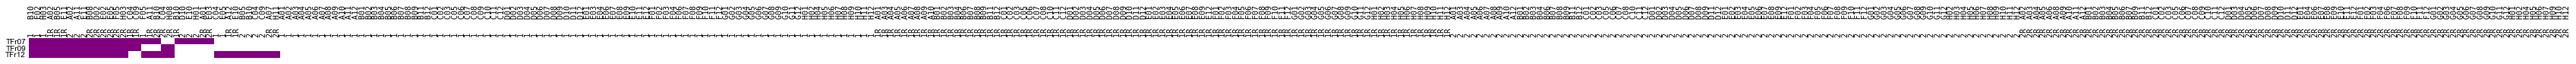

In [70]:
# something wrong with plate labels
# add Choi et al
# add me, Marc, Dave?
# save
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(60, 10)
checkerboard(data=df.pivot_table(index=['plate', 'scoring_pos'],
                                        columns='standard_batch',
                                        values='result').drop(columns=['TFr08', 'TFr10', 'TFr11'])
                         .reset_index(),
                   protein_a_column='plate',
                   protein_b_column='scoring_pos',
                  assay_labels=['TFr07', 'TFr09', 'TFr12'],
                 positive_color='purple')